In [ ]:
!pip install matplotlib
!pip install numpy
!pip install seaborn
!pip install tqdm
!pip install gymnasium==0.27.0
!pip install gymnasium[toy_text]
%matplotlib inline

In [ ]:
# Author: Till Zemann
# License: MIT License

from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym


# Let's start by creating the blackjack environment.
# Note: We are going to follow the rules from Sutton & Barto.
# Other versions of the game can be found below for you to experiment.

env = gym.make("Blackjack-v1", sab=True,render_mode="rgb_array")

In [ ]:
#reset the environment to get the first observation
done = False
observation, info = env.reset()

#observation = (16,9,False)


In [ ]:
# sample a random action from all valid actions
action = env.action_space.sample()
# action=1

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

# observation=(24, 10, False)
# reward=-1.0
# terminated=True
# truncated=False
# info={}

In [ ]:
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

In [ ]:
# hyperparameters
learning_rate = 0.01
n_episodes = 1000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

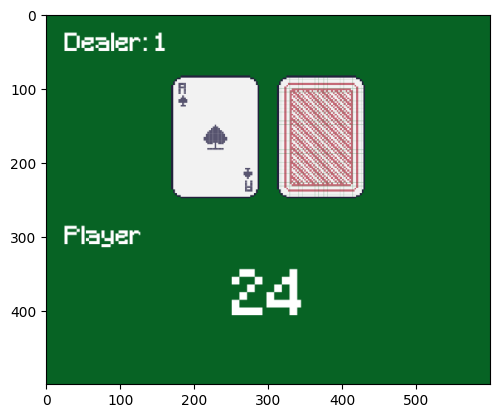

100%|██████████| 1000/1000 [07:26<00:00,  2.24it/s]


In [ ]:
from IPython.display import clear_output
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    clear_output()

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)
        frame = env.render()
        plt.imshow(frame)
        plt.show()
        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

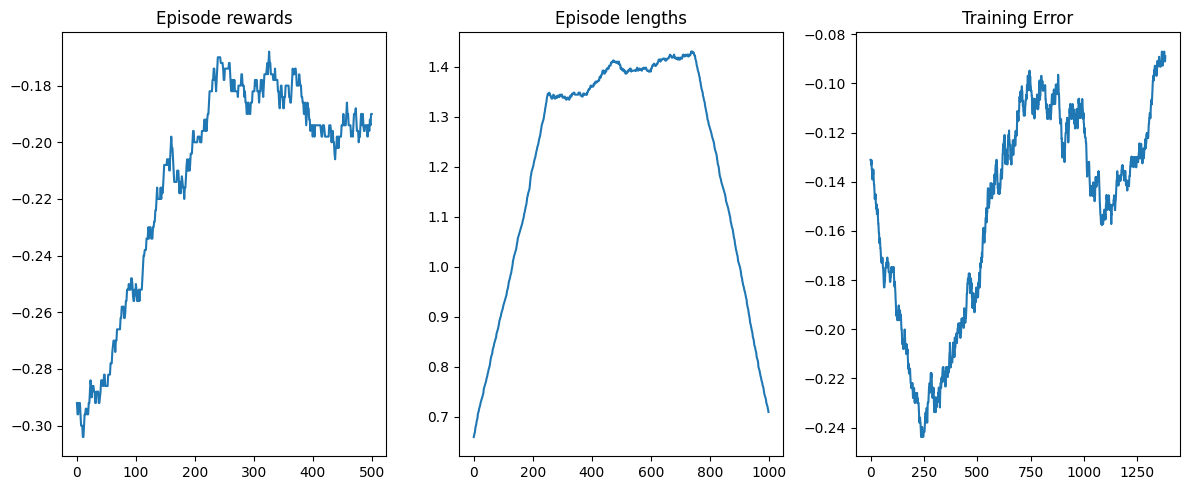

In [ ]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

In [ ]:
!pip install gymnasium[classic_control] collection

In [ ]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple,deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env=gym.make("CartPole-v1",render_mode="rgb_array")

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
  from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [ ]:
Transition = namedtuple('Transition',('state','action','next_state',
                                      'reward'))

class ReplayMemory(object):

  def __init__(self,capacity):
    self.memory = deque([],maxlen=capacity)

  def push(self,*args):
    self.memory.append(Transition(*args))
    """Save a transition"""

  def sample(self,batch_size):
    return random.sample(self.memory,batch_size)

  def __len__(self):
    return len(self.memory)


In [ ]:
class DQN(nn.Module):

  #multi-layer perceptron with three layers

  #n_observations is input(state of environment) to the network

  #n_actions  - number of possible action in the environment
  def __init__(self,n_observations,n_actions):
    super(DQN,self).__init__()
    self.layer1 = nn.Linear(n_observations,128)
    self.layer2 = nn.Linear(128,128)
    self.layer3 = nn.Linear(128,n_actions)

  #take and pass to 3 layer of the Neural Network

  def forward(self,x):
    x=F.relu(self.layer1(x))
    x=F.relu(self.layer2(x))
    return self.layer3(x)


In [ ]:
#number of transitions samples from the replay buffer
BATCH_SIZE = 128
# GAMMAis the discount factor
GAMMA = 0.99
EPS_START = 0.9 # it is  the starting value of epsilon
EPS_END = 0.05 # it is  the final value of epsilon
#EPS_DECAY controls the rate of exponential decay of epsilon,
#higher means slower decay
EPS_DECAY = 1000
TAU = 0.005 #Update rate of the target network
LR = 1e-4 #Learning rate of AdamW optimizer

In [ ]:
#Get number of actions from gym action space
n_actions = env.action_space.n

#Get the number of state observaation
state,info = env.reset()

#number of features in the state
n_observations = len(state)

#target net is initialized with same weight as `policy_net`
policy_net= DQN(n_observations,n_actions).to(device)
target_net= DQN(n_observations,n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

#optimizer - AdamW used to optimize the weights
optimizer = optim.AdamW(policy_net.parameters(),lr=LR ,amsgrad = True)

#it will store the agent's experiences , which will be used for training

memory = ReplayMemory(10000)

#keep track of number steps taken by the agent
steps_done = 0

#input - current state and return an action
def select_action(state):
  global steps_done
  sample = random.random()
  eps_threshold = EPS_END + (EPS_START- EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
  steps_done +=1
  if sample > eps_threshold:

    with torch.no_grad():
        #t.max(1) will return the largest column value of each row
        #second column on max result is index of where max element
        #was found , so we pick action with the larger expected reward
        return policy_net(state).max(1)[1].view(1,1)
  else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)



#It is used to keep track of the duration of each episode
episode_durations = []

#plot_durations  - visualize the training progress of the DQN
def plot_durations(show_result=False):
  plt.figure(1)
  durations_t = torch.tensor(episode_durations,dtype=torch.float)
  if show_result:
    plt.title('Result')
  else:
    plt.clf()
    plt.title('Training')
  plt.xlabel('Episode')
  plt.ylabel('Duration')
  plt.plot(durations_t.numpy())

  #shows the 100-episode moving average of the duration
  if(len(durations_t) >= 100):
    means = durations_t.unfold(0,1000,1).mean(1).view(-1)
    means = torch.cat((torch.zeroes(99),means))
    plt.plot(means.numpy())

  plt.pause(0.001) #pause so that plots are updated
  if is_ipython:
    if not show_result:
      display.display(plt.gcf())
      display.clear_output(wait=True)
    else:
      display.display(plt.gcf())



In [ ]:
def optimize_model():
  #check if we have enough samplke for a mini bacth
  if len(memory) < BATCH_SIZE:
    return

  #extract a mini-batch of transition(state,action,reward,next_state)
  # from the reply memory

  transition = memory.sample(BATCH_SIZE)

  #converts batch-array of Transitions to Transition of batch=arrays
  batch = Transition(*zip(*transition))

  #compute a mask of non-final states and concatente the
  #batch elements
  non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),device=device,dtype=torch.bool)

  non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
  state_batch = torch.cat(batch.state)
  action_batch = torch.cat(batch.action)
  reward_batch = torch.cat(batch.reward)


  state_action_values = policy_net(state_batch).gather(1,action_batch)

  next_state_values = torch.zeros(BATCH_SIZE,device=device)

  with torch.no_grad():
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

  #expect q-value for each transition using the target network
  #
  expected_state_action_values = (next_state_values * GAMMA) + reward_batch


  #Compute Huber loss
  #smooth approximation of the mean square error loss , less
  # sensitive

  criterion = nn.SmoothL1Loss()
  loss = criterion(state_action_values ,
                   expected_state_action_values.unsqueeze(1))

  #Optimize the model
  optimizer.zero_grad()
  loss.backward()

  #In-place gradient clipping
  #maximum value = 100 to prevent exploding gradient problem
  torch.nn.utils.clip_grad_value_(policy_net.parameters(),100)
  optimizer.step()

In [ ]:
#@title Default title text
if torch.cuda.is_available():
  num_episodes = 600
else:
  num_episodes = 50

#iterate for episodes
for i_episode in range(num_episodes):
  #intialize the environment and get it's state
  state,info = env.reset()
  state = torch.tensor(state,dtype=torch.float32,
                       device=device).unsqueeze(0)
  for t in count():
    action = select_action(state)
    observation , reward , terminated , truncated ,_ = env.step(action.item())
    reward = torch.tensor([reward],device = device)

    # frame = env.render()
    # plt.imshow(frame)
    # plt.show()

    done  = terminated or truncated

    if  terminated:
      next_state = None
    else:
      next_state = torch.tensor(observation,dtype=torch.float32,device=device).unsqueeze(0)

    #store the transition in memory
    memory.push(state,action,next_state,reward)

    #move to the next state
    state = next_state

    #optimize
    optimize_model()

  #soft update the target network's wright by bledning policy network's weights
  # and target network's weights using a hyperparameter called TAU
    target_net_state_dict  = target_net.state_dict()
    policy_net_state_dict  = target_net.state_dict()

    for key in policy_net_state_dict:
      target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1 - TAU)

    if done:
      episode_durations.append(t + 1)
      plot_durations()
      break

print('Complete')
plot_duration(show_result=True)
plt.ioff()
plt.show()


Complete


NameError: ignored

<Figure size 640x480 with 0 Axes>